In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [5]:
import os
import sys

# get the value of the environment variable $TMPDIR
tmp_dir = os.environ['TMPDIR']
print(tmp_dir)

os.makedirs(f'{tmp_dir}/FAUST_r/diffusion')

/tmp


In [6]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading
import my_code.datasets.shape_dataset as shape_dataset
import my_code.datasets.template_dataset as template_dataset



dataset_single = shape_dataset.SingleFaustDataset(
    phase='train',
    data_root = 'data_with_smpl_corr/FAUST_r',
    centering = 'bbox',
    num_evecs=128,
    # lb_cache_dir=f'/home/s94zalek_hpc/shape_matching/data_with_smpl_corr/FAUST_r/diffusion'
    lb_cache_dir=f'{tmp_dir}/FAUST_r/diffusion'
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


KeyError: 'C_gt_xy'

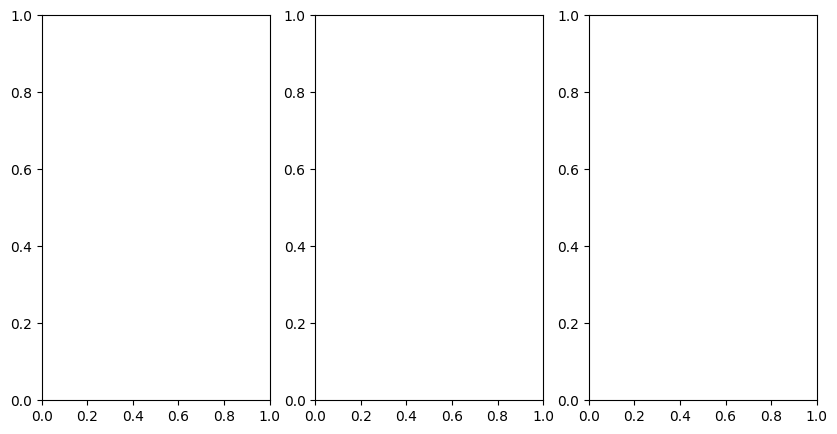

In [5]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], dataset_single[55]['C_gt_xy'][0],
                        'C_xy 55', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], dataset_single[67]['C_gt_xy'][0],
                        'C_xy 67', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], dataset_single[78]['C_gt_xy'][0],
                        'C_xy 78', l, h, show_grid=False, show_colorbar=False)



plt.show()

In [7]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0

feature_dim = 32
evecs_per_support = 4


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim,
    out_channels=feature_dim // evecs_per_support,
    cache_dir=None,
    input_type='wks',
    k_eig=64,
    n_block=6
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)
# add scheduler, decay by 0.1 every 30k iterations

scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1, end_factor=0.1, total_iters=50000)

In [8]:
# net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/notebooks/19.06.2024/sign_double_start_0_feat_64.pth'))
# net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/notebooks/03.07.2024/sign_double_start_0_feat_64_180xyz_scaling_09_11.pth'))
# net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_64_6block_factor4_180xyz_09_11_wks/39360.pth'))
# net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_64_6block_factor4_180xyz_09_11_noise0.01_meshLapl/39360.pth'))


input_type = 'wks'
net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_32_6block_factor4_dataset_SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1_wks/40000.pth'))

<All keys matched successfully>

## Test

In [12]:
from tqdm.auto import tqdm
import utils.geometry_util as geometry_util
import robust_laplacian
import scipy.sparse.linalg as sla
import utils.geometry_util as geometry_util
import my_code.sign_canonicalization.training as sign_training

tqdm._instances.clear()

# shapes_to_test = test_shapes
# net.cache_dir = test_diff_folder

net.cache_dir = dataset_single.lb_cache_dir
           
              
iterator = tqdm(range(1000))
incorrect_signs_list = torch.tensor([])
curr_iter = 0

for epoch in range(len(iterator) // len(dataset_single)):
    
    # train_shapes_shuffled = train_shapes.copy()
    # np.random.shuffle(test_shapes_list)
    
    
    for curr_idx in range(20):     


        ##############################################
        # Select a shape
        ##############################################
        
        test_shape = dataset_single[curr_idx]    
        
        verts = test_shape['verts'].unsqueeze(0).to(device)
        faces = test_shape['faces'].unsqueeze(0).to(device)
        evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

        ##############################################
        # Set the signs on shape 0
        ##############################################

        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_0[sign_gt_0 == 0] = -1
        sign_gt_0 = sign_gt_0.float().unsqueeze(0)

        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_0 = evecs_orig * sign_gt_0
        
        # predict the sign change
        with torch.no_grad():
            sign_pred_0, supp_vec_0, _ = sign_training.predict_sign_change(
                net, verts, faces, evecs_flip_0, evecs_cond=None, input_type=input_type)
        
        ##############################################
        # Set the signs on shape 1
        ##############################################
        
        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_1[sign_gt_1 == 0] = -1
        sign_gt_1 = sign_gt_1.float().unsqueeze(0)
        
        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_1 = evecs_orig * sign_gt_1
        
        # predict the sign change
        with torch.no_grad():
            sign_pred_1, supp_vec_1, _ = sign_training.predict_sign_change(
                net, verts, faces, evecs_flip_1, evecs_cond=None, input_type=input_type)
        
        ##############################################
        # Calculate the loss
        ##############################################
        
        # calculate the ground truth sign difference
        sign_diff_gt = sign_gt_1 * sign_gt_0
        
        # calculate the sign difference between predicted evecs
        sign_diff_pred = sign_pred_1 * sign_pred_0
        
        sign_correct = sign_diff_pred.sign() * sign_diff_gt.sign() 
        
        
        # count the number of incorrect signs
        count_incorrect_signs = (sign_correct < 0).int().sum()
            
        # incorrect_signs_list.append(count_incorrect_signs)
        incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
        
        
        iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}')
        iterator.update(1)
        # if count_incorrect_signs > 7:
        #     raise ValueError('Too many incorrect signs')
    
iterator.close()
    
print(f'Results for {len(incorrect_signs_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_signs_list.float().mean():.2f} / {feature_dim}')

print('Max incorrect signs', incorrect_signs_list.max())

print()
# print('Shape idx', curr_idx)
print('GT', sign_diff_gt)
print('PRED', sign_diff_pred)
print('Correct', sign_correct)
print(f'Incorrect signs {torch.sum(sign_correct != 1)} / {feature_dim}')
print(incorrect_signs_list)


# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!ls $TMPDIR/FAUST_r/diffusion

In [13]:
import pandas as pd

# read /home/s94zalek_hpc/shape_matching/notebooks/31.07.2024/diffusionnet_runtime_profile.csv
df = pd.read_csv('/home/s94zalek_hpc/shape_matching/notebooks/31.07.2024/diffusionnet_runtime_profile.csv')



In [21]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# sort df by 'cumtime'
df = df.sort_values(by='cumtime', ascending=False)
# print(df.head(10))
df.head(20)[['func','ncalls','ccalls','tottime','cumtime']]

## Which shapes have the most incorrect signs?

In [ ]:
# print indices where incorrect_signs_list > 10
print('incorrect > 10, % 20:', torch.where(incorrect_signs_list > 3)[0] % 20)
print('incorrect > 10:', torch.where(incorrect_signs_list > 3)[0])

# for each index % 0 - 19, print the mean number of incorrect signs

unique_shape_idx = torch.zeros(20)
for i in range(len(incorrect_signs_list)):
    unique_shape_idx[i % 20] += incorrect_signs_list[i]
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(unique_shape_idx)
axs[0].set_title('Incorrect signs per unique test shape')

incorrect_signs_1 = []
incorrect_signs_11 = []
for i in range(len(incorrect_signs_list)):
    if i % 20 == 11:
        incorrect_signs_11.append(incorrect_signs_list[i])
    if i % 20 == 1:
        incorrect_signs_1.append(incorrect_signs_list[i])
        
axs[1].plot(incorrect_signs_1, '.', label='shape 1')
axs[1].plot(incorrect_signs_11, '.', label='shape 11')

axs[1].set_title('Incorrect signs for shape 1 and 11')
plt.legend()

plt.show()

In [ ]:
scene.geometry.clear()

# mesh_orig = trimesh.Trimesh(vertices=test_shapes[173]['verts'], faces=test_shapes[11]['faces'])
# scene.add_geometry(mesh_orig)

# mesh_orig = trimesh.Trimesh(vertices=test_shapes[224]['verts'] + torch.tensor([1, 0, 0])
#                             , faces=test_shapes[101]['faces'])
# scene.add_geometry(mesh_orig)

for i, shape_idx in enumerate(torch.where(incorrect_signs_list > 10)[0]):
    mesh_orig = trimesh.Trimesh(vertices=test_shapes[shape_idx]['verts'] + torch.tensor([i, 0, 0])
                                , faces=test_shapes[shape_idx]['faces'])
    scene.add_geometry(mesh_orig)


axis = trimesh.creation.axis(axis_length=0.5)
scene.add_geometry(axis)

scene.show()

## Check the evecs on failed shapes

In [ ]:
from utils.geometry_util import get_operators
import my_code.utils.plotting_utils as plotting_utils
import robust_laplacian
import scipy.sparse.linalg as sla
import utils.geometry_util as geometry_util
import potpourri3d as pp3d

evec_n = 60

feature_dim = 64

scene.geometry.clear()

verts_0 = test_shapes[0]['verts']
faces_0 = test_shapes[0]['faces']
# evecs_0 = test_shapes[11]['evecs'][:, start_dim:start_dim+feature_dim]
# evecs_0 = torch.nn.functional.normalize(evecs_0, p=2, dim=0)

# verts_0 = verts_0 * 2.5

# L_0 = pp3d.cotan_laplacian(verts_0.numpy(), faces_0.numpy(), denom_eps=1e-10)
# M_0 = pp3d.vertex_areas(verts_0.numpy(), faces_0.numpy())
# M_0 += 1e-8 * np.mean(M_0)
# M_0 = np.diag(M_0).astype(np.float32)

# print(L_0.dtype, M_0.dtype)

L_0, M_0 = robust_laplacian.mesh_laplacian(verts_0.numpy(), faces_0.numpy())
# L_0, M_0 = robust_laplacian.point_cloud_laplacian(verts_0.numpy())
evals_0, evecs_0 = sla.eigsh(L_0, feature_dim, M_0, sigma=1e-8)
evecs_0 = torch.tensor(evecs_0)


verts_1 = test_shapes[1]['verts']
faces_1 = test_shapes[1]['faces']
# evecs_1 = test_shapes[91]['evecs'][:, start_dim:start_dim+feature_dim]
# evecs_1 = torch.nn.functional.normalize(evecs_1, p=2, dim=0)

# L_1 = pp3d.cotan_laplacian(verts_1.numpy(), faces_1.numpy(), denom_eps=1e-10)
# M_1 = pp3d.vertex_areas(verts_1.numpy(), faces_1.numpy())
# M_1 += 1e-8 * np.mean(M_1)
# M_1 = np.diag(M_1).astype(np.float32)

L_1, M_1 = robust_laplacian.mesh_laplacian(verts_1.numpy(), faces_1.numpy())
# L_1, M_1 = robust_laplacian.point_cloud_laplacian(verts_1.numpy())
evals_1, evecs_1 = sla.eigsh(L_1, feature_dim, M_1, sigma=1e-8)
evecs_1 = torch.tensor(evecs_1)


cmap_0 = trimesh.visual.color.interpolate(
    torch.nn.functional.normalize(evecs_0[:, evec_n], p=2, dim=0),
    'bwr')

cmap_1 = trimesh.visual.color.interpolate(
    torch.nn.functional.normalize(evecs_1[:, evec_n], p=2, dim=0)
    , 'bwr')


# chng_by_evec = (evecs_0.abs() - evecs_1.abs()).abs().sum(dim=0)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(evecs_0[:, evec_n].abs().cpu().numpy(), label='11')
axs[0].plot(evecs_1[:, evec_n].abs().cpu().numpy(), label='101')
axs[0].legend()

C_orig_rot = torch.linalg.lstsq(evecs_0, evecs_1).solution
plotting_utils.plot_Cxy(fig, axs[1], C_orig_rot,
                        'C_orig_rot', 0, 64, show_grid=False, show_colorbar=False)


plt.show()


mesh_0 = trimesh.Trimesh(vertices=verts_0, faces=faces_0, vertex_colors=cmap_0[:len(verts_0)])
mesh_1 = trimesh.Trimesh(vertices=verts_1 + np.array([1, 0, 0]), faces=faces_1,
                           vertex_colors=cmap_1[:len(verts_1)])

scene.add_geometry(mesh_0)
scene.add_geometry(mesh_1)

axis = trimesh.creation.axis(axis_length=1)
scene.add_geometry(axis)

scene.show()

In [ ]:
evals_0[l:h].mean(), evals_1[l:h].mean()

In [ ]:
l = 48
h = 64


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(evals_0[l:h], '.-', label='evals_0')
axs[0].plot(evals_1[l:h], '.-', label='evals_1')

axs[1].plot(evals_0[l:h] - evals_0[l:h].mean(), '.-', label='evals_0')
axs[1].plot(evals_1[l:h] - evals_1[l:h].mean(), '.-', label='evals_1')


# plt.plot(train_dataset[78]['second']['evals'][0][l:h], '.-', label='evals_78')

plt.legend()
# plt.yscale('log')

plt.show()

In [ ]:
plot = plt.imshow((supp_vec_0.transpose(1, 2) @ evecs_flip_0)[0].cpu(), cmap='bwr')
plt.colorbar(plot)
plt.show()

In [ ]:
# marker color = blue if incorrect, red if correct
color = np.where(sign_correct.squeeze().detach().cpu().numpy() == 1, 'red', 'blue')

plt.scatter(np.arange(feature_dim), sign_diff_pred.squeeze().detach().cpu().numpy(), c=color)

# plt.ylim(-0.3, 0.3)
plt.axhline(0, color='black', linewidth=0.5)
# plt.plot(sign_correct.squeeze().detach().cpu().numpy(), '.')

In [ ]:
# fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# for i, idx in enumerate(range(1, 4)):
#     axs[i].plot(supp_vec_0[0, :, -idx].cpu(), '-')
plt.plot(supp_vec_0[0, :, -4].cpu(), '-')
plt.plot(supp_vec_1[0, :, -4].cpu(), '-')
plt.show()

In [ ]:
scene.geometry.clear()

verts = test_shape['verts'].cpu().numpy()
faces = test_shape['faces'].cpu().numpy()

cmap = np.ones((verts.shape[0], 4))

# set cmap to 1 where supp_vec_0[0, :, -4] > 0.02
cmap[supp_vec_0[0, :, -2].cpu().abs() > 0.015, :2] = 0
# cmap *= 255

mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_colors=cmap)
scene.add_geometry(mesh)

scene.show()

## Time complexity

In [ ]:
import time

train_shape = train_dataset[58]['second']
verts_orig = train_shape['verts']
faces = train_shape['faces']

time_start = time.time()

for i in range(10):
    _, _, _, _, evecs_orig, _, _ = get_operators(verts_orig, faces,
                                                    k=feature_dim,
                                                    cache_dir=None)
time_get_operators = time.time() - time_start

for i in range(10):
    L_orig, M_orig = robust_laplacian.mesh_laplacian(verts_orig.numpy(), faces.numpy())
    # L_orig, M_orig = robust_laplacian.point_cloud_laplacian(verts_orig.numpy())
    evals_orig, evecs_orig = sla.eigsh(L_orig, feature_dim, M_orig, sigma=1e-8)
    evecs_orig = torch.tensor(evecs_orig)

time_robust_laplacian = time.time() - time_start - time_get_operators

print(f'time_get_operators: {time_get_operators}')
print(f'time_robust_laplacian: {time_robust_laplacian}')
